# Tarea 2 - Regresión

- Di Carlo, Martina
- Pastrana Analía
- Suárez Gilda

Utilizando un regresor basado en árboles de decisión estime el error de predicción sobre la variable objetivo a medida que varía la complejidad del árbol. Verifique dicha predicción utilizando un conjunto de test. Compare el error de train del método de regresión con el de test. Realice la tarea con el conjuntos de datos: Life_Expectancy_Data.csv.   
En este caso la variable objetivo se llama 'Life expectancy '. Discuta los resultados obtenidos brevemente.
Tener en cuenta que la clase de sklearn DecisionTreeRegressor controla la complejidad del árbol con el parámetro ccp_alpha. Recuerde explicar en las gráficas como varía la complejidad respecto a ccp_alpha. ¿Cuándo se vuelve más complejo el árbol ? 
Resuelva utilizando KFold, porque no se puede usar StratifiedKFold ?  

In [1]:
import pandas as pd
pd.options.display.max_columns=None
pd.options.display.max_rows=None

import numpy as np

import janitor as j
from pyprojroot import here

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.ensemble import BaggingRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
path_data = here() / 'Martu' / 'Maestria' / 'data_mining' / 'practico2' / 'Datos'
path_data

WindowsPath('C:/Users/dicarlom/Desktop/Martu/Maestria/data_mining/practico2/Datos')

In [3]:
df = pd.read_csv(path_data / 'Life_Expectancy_Data.csv')\
       .clean_names()\
       .encode_categorical(["country", "status"])

In [4]:
df.head()

,country,year,status,life_expectancy_,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles_,_bmi_,under_five_deaths_,polio,total_expenditure,diphtheria_,_hiv_aids,gdp,population,_thinness_1_19_years,_thinness_5_9_years,income_composition_of_resources,schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [5]:
df.shape

(2938, 22)

In [6]:
target_na = df.life_expectancy_.notna()
df = df[target_na]

## EDA

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   country                          2928 non-null   category
 1   year                             2928 non-null   int64   
 2   status                           2928 non-null   category
 3   life_expectancy_                 2928 non-null   float64 
 4   adult_mortality                  2928 non-null   float64 
 5   infant_deaths                    2928 non-null   int64   
 6   alcohol                          2735 non-null   float64 
 7   percentage_expenditure           2928 non-null   float64 
 8   hepatitis_b                      2375 non-null   float64 
 9   measles_                         2928 non-null   int64   
 10  _bmi_                            2896 non-null   float64 
 11  under_five_deaths_               2928 non-null   int64   
 12  polio 

In [8]:
df.country.nunique()

183

In [9]:
df.year.nunique()

16

[]

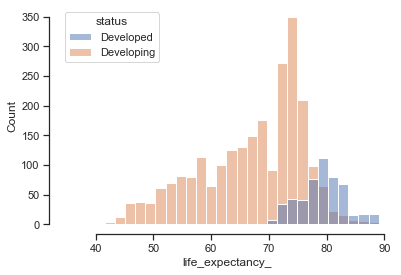

In [10]:
sns.set_theme(style="ticks")
sns.histplot(x = 'life_expectancy_', 
             hue = 'status',
            data = df)
sns.despine(offset=10, trim=True)
plt.plot()

[]

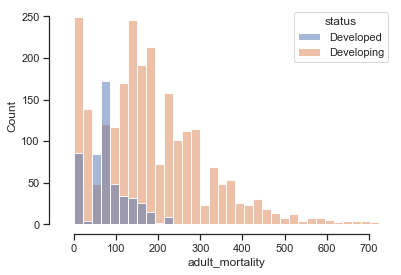

In [11]:
sns.set_theme(style="ticks")
sns.histplot(x = 'adult_mortality', 
             hue = 'status',
            data = df)
sns.despine(offset=10, trim=True)
plt.plot()

In [12]:
df['infant_deaths'].describe()

count    2928.000000
mean       30.407445
std       118.114450
min         0.000000
25%         0.000000
50%         3.000000
75%        22.000000
max      1800.000000
Name: infant_deaths, dtype: float64

[]

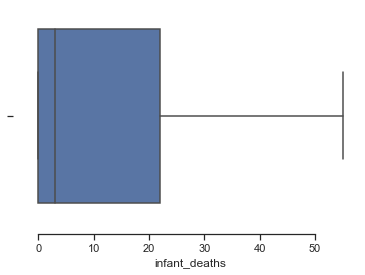

In [13]:
sns.set_theme(style="ticks")
sns.boxplot(x = 'infant_deaths', 
            showfliers = False,         
            data = df)
sns.despine(offset=10, trim=True)
plt.plot()

#### Nulos:

In [14]:
df_nuls = pd.DataFrame(df.isna().sum()/df.shape[0]*100).reset_index()
df_nuls.rename(columns = {0: 'porcentaje_nul',
                         'index' : 'col'},inplace = True)
con_nulos = df_nuls.porcentaje_nul > 0
df_nuls[con_nulos]

,col,porcentaje_nul
6,alcohol,6.591530
8,hepatitis_b,18.886612
10,_bmi_,1.092896
12,polio,0.648907
13,total_expenditure,7.718579
14,diphtheria_,0.648907
16,gdp,15.129781
17,population,21.994536
18,_thinness_1_19_years,1.092896
19,_thinness_5_9_years,1.092896


In [15]:
cols = df_nuls[con_nulos].col.to_list()
cols1 = cols.copy()
cols1.append('country')
cols1.append('year')

Llenamos con la media de cada pais, si podemos

In [16]:
medias = df.groupby('country').mean()\
           .reset_index()\
           .add_prefix('mean_')

In [17]:
df = df.merge(medias,
               left_on = 'country',
               right_on = 'mean_country',
              how = 'left')

In [18]:
for col in cols:
    df[col] = (df[col].combine_first(df['mean_' +  col]))

In [19]:
df[cols].isna().sum()

alcohol                             16
hepatitis_b                        144
_bmi_                               32
polio                                0
total_expenditure                   32
diphtheria_                          0
gdp                                400
population                         640
_thinness_1_19_years                32
_thinness_5_9_years                 32
income_composition_of_resources    160
schooling                          160
dtype: int64

Como seguimos teniendo nulos, al resto los llenamos con la media de la columna

In [20]:
df[cols] = df[cols].apply(lambda x: x.fillna(x.mean()),axis=0)

In [21]:
df[cols].isna().sum()

alcohol                            0
hepatitis_b                        0
_bmi_                              0
polio                              0
total_expenditure                  0
diphtheria_                        0
gdp                                0
population                         0
_thinness_1_19_years               0
_thinness_5_9_years                0
income_composition_of_resources    0
schooling                          0
dtype: int64

In [22]:
columnas = [c for c in df.columns if c.lower()[:5] != 'mean_']
df = df[columnas]

### Data preparation

In [23]:
X = df.drop(columns = 'life_expectancy_', axis = 1)
y = df.life_expectancy_

Como utilizaremos arboles tenemos que cambiar las variables a numéricas

In [24]:
for n in X.columns:
    if 'object' in str(X[n].dtype) or 'category' in str(X[n].dtype):
        X[n] = X[n].astype('category').cat.codes

In [25]:
X.head()

,country,year,status,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles_,_bmi_,under_five_deaths_,polio,total_expenditure,diphtheria_,_hiv_aids,gdp,population,_thinness_1_19_years,_thinness_5_9_years,income_composition_of_resources,schooling
0,0,2015,1,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,0,2014,1,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,0,2013,1,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,0,2012,1,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,0,2011,1,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


#### Split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, 
                                                    random_state=17)

#### Escalado

In [27]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### Cross Validation

En este caso utilizaremos KFold y no StratifiedKFold, ya que tenemos un problema de regresión y no tenemos clases que querramos que queden divididas de manera estratificada.

In [28]:
par = list(np.arange(0, 1, step=0.01))
cv = KFold(n_splits=5, 
           random_state=0, 
           shuffle=True)

### Decision Tree

In [29]:
tunner_t = GridSearchCV(estimator=DecisionTreeRegressor(), 
                            param_grid={'ccp_alpha':par}, 
                            cv=cv)

In [30]:
_=tunner_t.fit(X_train, y_train)

In [31]:
y_tr_pred = tunner_t.predict(X_train)

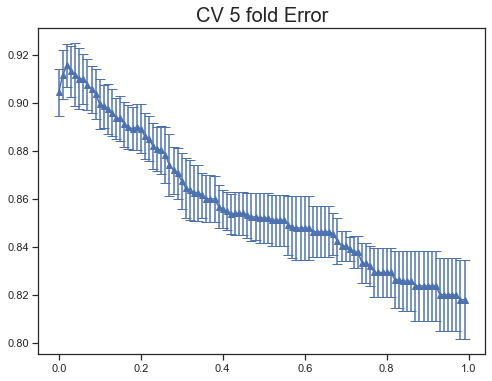

In [32]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.errorbar(tunner_t.cv_results_['param_ccp_alpha'], 
            tunner_t.cv_results_['mean_test_score'], 
            yerr=tunner_t.cv_results_['std_test_score'], 
            capsize=5,
            marker='^')
_=ax.set_title('CV 5 fold Error', fontsize=20)

A medida que el alfa se hace mayor va cayendo el score en test.

#### Train validation

In [33]:
print(r2_score(y_train, y_tr_pred))

0.9713836280053547


#### Test validation

In [34]:
y_te_pred = tunner_t.predict(X_test)

In [35]:
print(r2_score(y_test, y_te_pred))

0.926759580516752


In [36]:
tunner_t.best_params_

{'ccp_alpha': 0.02}

Vemos que el score de train es .97, el de test .93. Y nuestro alfa de 0.02. Si bien existió cierto tipo de penalización podemos imaginar un arbol sobreajustado. 

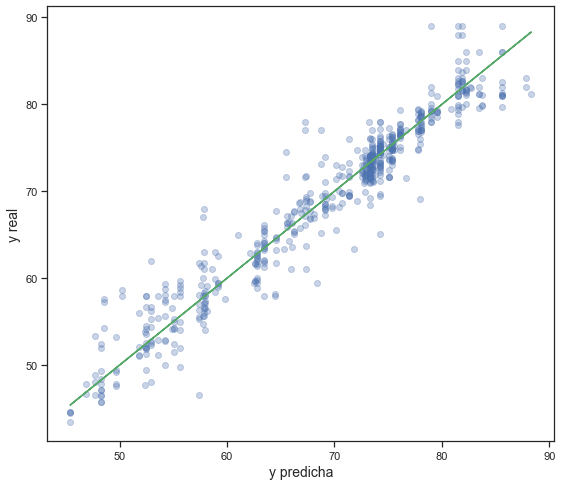

In [37]:
fig = plt.figure(figsize=(20,8))

ax = fig.add_subplot(121)
ax.scatter(y_te_pred, y_test, alpha=0.3)
ax.plot(y_te_pred, y_te_pred, c='g')
ax.set_xlabel('y predicha', fontsize=14)
ax.set_ylabel('y real', fontsize=14)

plt.show()

### BaggingRegressor


Repetir utilizando BaggingRegressor con 30 estimadores para el modelo cuyo alpha
presenta el mejor error de predicción. Analizar cómo varía el error de test para dicho
BaggingRegressor al utilizar [2, 5, 10, 20, 40, 80, 150, 300, 500] estimadores.
Compare con el error de test del árbol cuyo alpha presenta el mejor error de
predicción. Discuta los resultados brevemente. (5 pts.)

In [38]:
n_estimadores = [2, 5, 10, 20, 40, 80, 150, 300, 500]
cv = KFold(n_splits=5)

In [39]:
t = DecisionTreeRegressor()
par = list(np.arange(0.005, 1., step=0.05))
bag = BaggingRegressor(base_estimator=t, n_estimators=30, random_state=0, n_jobs=-1)
tunner_bag = GridSearchCV(estimator=bag, param_grid={'base_estimator__ccp_alpha':par}, cv=cv)
_=tunner_bag.fit(X_train, y_train)

In [40]:
y_tr_pred = tunner_bag.predict(X_train)

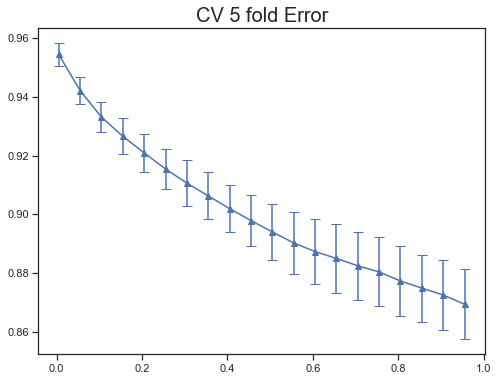

In [41]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.errorbar(tunner_bag.cv_results_['param_base_estimator__ccp_alpha'], 
            tunner_bag.cv_results_['mean_test_score'], 
            yerr=tunner_bag.cv_results_['std_test_score'], 
            capsize=5,
            marker='^')
_=ax.set_title('CV 5 fold Error', fontsize=20)

A medida que el alfa se hace mayor va cayendo el score en test.

#### Train validation

In [42]:
print(r2_score(y_train, y_tr_pred))

0.9906219341754465


#### Test validation

In [43]:
y_te_pred = tunner_bag.predict(X_test)

In [44]:
print(r2_score(y_test, y_te_pred))

0.9662715031154541


In [45]:
tunner_bag.best_params_

{'base_estimator__ccp_alpha': 0.005}

Vemos que para alfas mas chicos el arbol es mas complejo

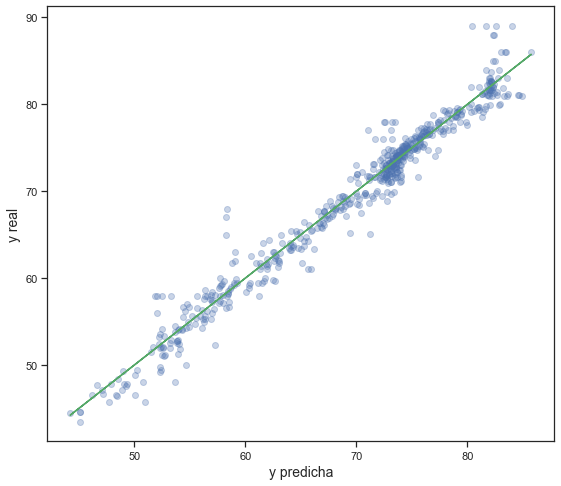

In [46]:
fig = plt.figure(figsize=(20,8))

ax = fig.add_subplot(121)
ax.scatter(y_te_pred, y_test, alpha=0.3)
ax.plot(y_te_pred, y_te_pred, c='g')
ax.set_xlabel('y predicha', fontsize=14)
ax.set_ylabel('y real', fontsize=14)

plt.show()

Cuando usamos 30 estimadores, vemos que los scores de train y testing se parecen un poco mas. Esto nos ayuda a disminuir el sobreajuste.

### Variando n_estimators

In [47]:
t1 = DecisionTreeRegressor(ccp_alpha=0.005)

bag1 = BaggingRegressor(base_estimator=t1,random_state=0, n_jobs=-1)

tunner_bag1 = GridSearchCV(estimator=bag1, 
                          param_grid={'n_estimators':[2, 5, 10, 20, 40, 80, 150, 300, 500]}, 
                          cv=cv)
_=tunner_bag1.fit(X_train, y_train)

In [48]:
y_tr_pred1 = tunner_bag1.predict(X_train)

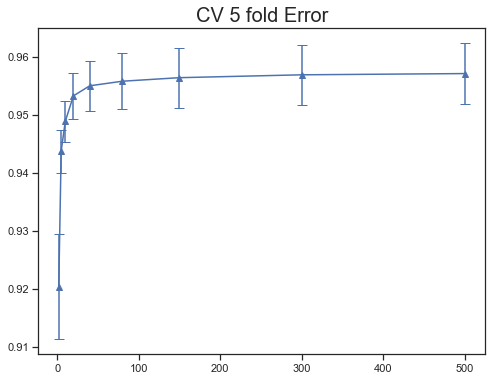

In [49]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.errorbar(tunner_bag1.cv_results_['param_n_estimators'], 
            tunner_bag1.cv_results_['mean_test_score'], 
            yerr=tunner_bag1.cv_results_['std_test_score'], 
            capsize=5,
            marker='^')
_=ax.set_title('CV 5 fold Error', fontsize=20)

In [50]:
tunner_bag1.best_params_

{'n_estimators': 500}

#### Train validation

In [51]:
print(r2_score(y_train, y_tr_pred1))

0.9919417429427633


#### Test validation

In [52]:
y_te_pred1 = tunner_bag1.predict(X_test)

In [53]:
print(r2_score(y_test, y_te_pred1))

0.9675951808198942


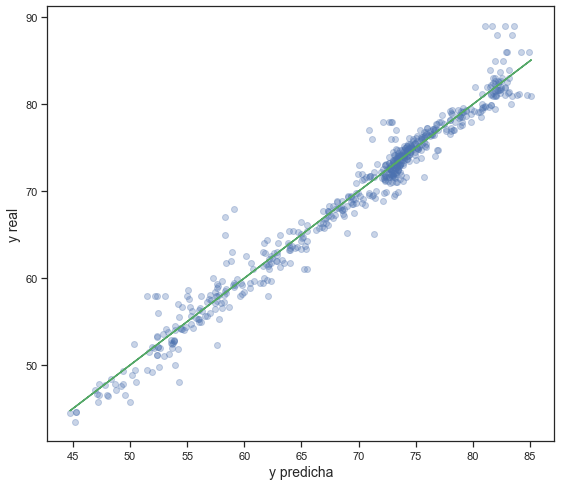

In [54]:
fig = plt.figure(figsize=(20,8))

ax = fig.add_subplot(121)
ax.scatter(y_te_pred1, y_test, alpha=0.3)
ax.plot(y_te_pred1, y_te_pred1, c='g')
ax.set_xlabel('y predicha', fontsize=14)
ax.set_ylabel('y real', fontsize=14)

plt.show()

Con 500 estimadores pasa algo muy similar a los 30. Al realizar bagging lo que hacemos es ensamblar estimadores que fitean regresores con subsets random del dataset original y luego agrega las predicciones individuales para armar una predicción final. Esto permite reducir la varianza de las predicciones a través de la combinación de los resultados de varios clasificadores, evitando el sobreajuste.